In [1225]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import random

# 1.) Data Preprocessing

### a. Load the raw Data

In [1226]:
train = np.load('train_data.npy')
train_label = np.load('train_label.npy')

test = np.load('test_data.npy')
test_label = np.load('test_label.npy')

X = train

# Reduce redundant dimension
y = train_label.squeeze()

X_test = test

# Reduce redundant dimension
y_test = test_label.squeeze()

###b. Data Scaling

In [1227]:
scaled_X = (X - X.mean(axis = 0, keepdims=True)) / X.std(axis = 0, keepdims=True)
X_test = (X_test - X_test.mean(axis = 0, keepdims=True)) / X_test.std(axis = 0, keepdims=True)

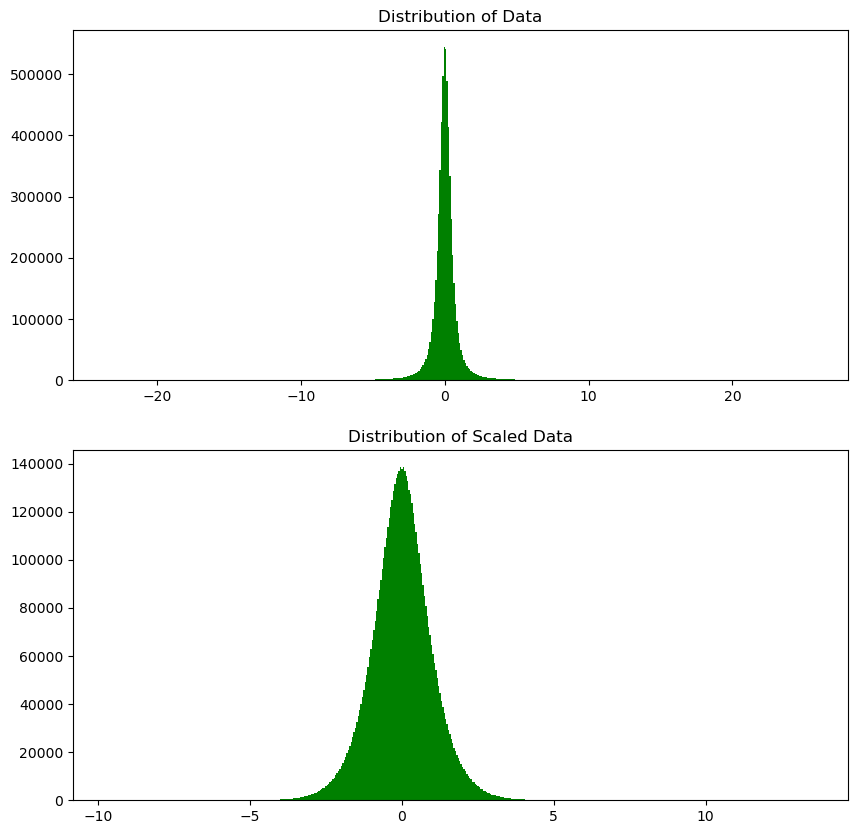

In [1228]:
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].hist(X.flatten(), bins=500,color='green')
axs[0].set_title('Distribution of Data')

axs[1].hist(scaled_X.flatten(), bins=500,color='green')
axs[1].set_title('Distribution of Scaled Data')
plt.show()

X = scaled_X


###c. Label Encoding

In [1229]:
print('Original Target label:\n', y[1:10])

Original Target label:
 [9 9 4 1 1 2 7 8 3]


In [1230]:
# Label Encode the Training set
y = np.array(np.eye(10)[y], dtype=float)

# Label Encode the Testing set
y_test = np.array(np.eye(10)[y_test], dtype=float)

In [1231]:
print('Encoded Target label: \n', y[1:10])

Encoded Target label: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


### d. Train Valid Split

In [1232]:
def splitData(X, y, test_rate=0.2):
    # Obtain the data size
    Train_data_size= int(X.shape[0] * test_rate)

    # Randomly select index from the data
    Randomized_index = np.random.permutation(X.shape[0])

    # Divide train data index and validation data index 
    data_training_index = Randomized_index[:Train_data_size]
    data_testing_index = Randomized_index[Train_data_size:]

    X_train = X[data_training_index]
    y_train = y[data_training_index]

    Validation_X = X[data_testing_index]
    Validation_y = y[data_testing_index]

    return X_train, y_train, Validation_X, Validation_y

In [1233]:
X_train, y_train, X_valid, y_valid = splitData(X,y)

# 2.) Create a Nerual Network



### a. Create Layer Class

1. Create neuron unit 

2. Create a drop out features to omit some neuron

3. Create Layer_input to initialize the training process


In [1234]:
class Layer_Dense():
    
    # Initialize Layer with neccessary parameter &
    # advanced parameters for optimization and regularization algorithm
    def __init__(self, n_inputs, n_neurons, norm = False,weight_reg_l2=0.):

        # Generate gamma and beta for batch normalization
        self.gamma = np.ones((1,n_inputs))
        self.beta = 0
    
        # Initalize with randomly generate weights using guassian distribution
        random.seed(888)
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons) # mu : 0, sigma : 1
        self.biases = np.zeros((1, n_neurons))

        # Set the regularization parameter for weight decay
        self.weight_reg_l2 = weight_reg_l2
        
    # Feed foward Calculation
    def forward(self, inputs, training, norm = False, error_BN=1e-10 ):
        self.inputs = inputs

        if norm:
            # Normalize data computation
            self.sample_mean = self.inputs.mean(axis=0, keepdims=True)
            self.sample_var = self.inputs.var(axis=0, keepdims=True)
            self.x_norm  = (self.inputs - self.sample_mean) // np.std(self.sample_var + error_BN) # avoid divided by 0
            inputs = self.x_norm.copy()
            
            # Use gamma, beta to calculate normalized output
            inputs = inputs * self.gamma + self.beta
            inputs = np.dot(inputs,self.weights) + self.biases

        # Using weight, bias to calculate output
   
        self.output = np.dot(inputs,self.weights) + self.biases
        
    # Backpropogation pass
    def backward(self, dvalues, norm=False):
        
        if norm:     
                
            invN = 1. / np.prod(self.sample_mean.shape)

            # dvalues : derivative from previous layer
            # Compute the gradient of guassian distribution function
            self.dweights = np.dot(self.inputs.T, dvalues)
            self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

            self.dvalues = np.dot(dvalues, self.weights.T)

            self.sample_mean_dvalues = (self.dvalues * (-self.sample_var)).mean(axis=0)   
            self.sample_var_dvalues  = ((self.dvalues * (self.inputs - self.sample_mean)).sum(axis=0) *
                            (-.5 * self.sample_var ** 3 ))     
            
            self.dvalues = (self.dvalues * self.sample_var_dvalues +
                    self.sample_var_dvalues * 2 * (self.inputs - self.sample_mean) * invN +
                    self.sample_mean_dvalues * invN)
        
            
        # dvalues : derivative from previous layer
        # Compute the gradients using dvalues
        else:
    
            self.dweights = np.atleast_2d(self.inputs).T.dot(np.atleast_2d(dvalues))
            self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Compute the gradient of weight decay regularization

        if self.weight_reg_l2 > 0:
          self.dweights += 2 * self.weight_reg_l2 * self.weights

        # Compute the gradients of values
        self.dinputs = np.dot(dvalues, self.weights.T)
    
    # Remember layers' weight and bias 
    def get_parameters(self):
      return self.weights, self.biases




class Layer_Dropout():
    
    # Initialize Layer dropout with a specific rate
    def __init__(self,rate):

        self.rate = 1 - rate 
    
    # Feed forward ( filter out random neurons at specific rate after neuron calculation)
    def forward(self, inputs, training):

        self.inputs = inputs
        
        # Do not need to filter out neurons during model evaluation
        if not training:
            self.output = inputs.copy()
            return
        
        # Use binomial distribution to randomly pick neurons at specific rate
        self.binary_mask = np.random.binomial(1, self.rate, size = inputs.shape)/self.rate
        self.output = inputs * self.binary_mask
    
    # Backpropogation pass
    def backward(self, dvalues):

        # Use binomial distribution above to randomly pick gradient values coming back
        self.dinputs = dvalues * self.binary_mask



# The very first Layer input       
class Layer_Input():
    
    # Forward calculation
    def forward(self, inputs, training):
        self.output = inputs

### b. Create Activation Function Class

1. Create Leaky ReLu activation function

2. Create Softmax for multi-class classification activation function

3. Create Sigmoid activation function


In [1235]:
class Activation_ReLu():
    
    # Feed forward
    def forward(self,inputs, training):

        # input here is the computation after w * x + b
        # Pick the maximum between input values and a extremely small value
        self.inputs = inputs
        self.output = np.maximum( 1e-10 * inputs, inputs)
        
    # Backpropogation
    def backward(self,dvalues):

        # Compute the gradient of Leaky ReLu function
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 1e-10
    
class Activation_Softmax():

     # Feed forward
    def forward(self, inputs,training):
        
        self.inputs = inputs

        # Compute the exponential component of softmax function
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Compute the probability of belonging to each class
        proba = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = proba

    # Backpropogation
    def backward(self, dvalues):
        
        # Compute the derivative of softmax function

        # Create a similar array as derivative 
        self.dinputs = np.empty_like(dvalues)

        # Compute a jacobian matrix contain the partial derivatives (gradient) of each class
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

    # Compute the prediction 
    def predictions(self,outputs):
        return np.argmax(outputs, axis=1)

class Activation_Sigmoid():
    
    # Feed forward 
    def forward(self, inputs, training):
        
        # Compute the signmoid function
        self.input = inputs
        self.output = 1 / (1 + np.exp(-inputs))
    
    # Backpropogation
    def backward(self,dvalues):
        
        # Compute the gradient of sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output
        


### c. Create Optimization Class

1. Create Stochastic Gradient Descent

3. Create Adam Optimization


In [1236]:
class SGD():
    # Initialize neccessary parameters
    def __init__(self, learning_rate=0.1, decay=0., momentum=0.):
        
        self.learning_rate = learning_rate
        self.live_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    # Update the learning rate
    def pre_update_params(self):
        
        # Compute the updated learning rate if decay is initialized
        if self.decay:

            self.live_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.iterations))

    # Update the weights and biases during backpropogation
    def update_params(self,layer):
        
        # Compute the delta if momentum initialized
        if self.momentum:
            
            # Create a same shape matrix if layer does not has attribute weight_momentums
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)

                layer.biases_momentums = np.zeros_like(layer.biases)

            # Compute the delta weights combining momentum and gradient descent
            weight_updates = self.momentum * layer.weight_momentums - self.live_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Compute the delta biases combining momentum and gradient descent
            biases_updates = self.momentum * layer.biases_momentums - self.live_learning_rate * layer.dbiases
            layer.biases_momentums = biases_updates

        # Compute the delta if momentum not initialized
        else:
            weight_updates = -self.live_learning_rate * layer.dweights
            biases_updates = -self.live_learning_rate * layer.dbiases

        # Update the weights and biases values
        layer.weights += weight_updates
        layer.biases += biases_updates

    # Update the iterations after updating bias and weight
    # To conttinue the learning rate decay for next update 
    def post_update_params(self):
        self.iterations += 1

class Adam():

    # Initialize neccessary parameters
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-10,beta_1=0.,beta_2=0.):

        self.learning_rate = learning_rate
        self.live_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Update the learning rate before computing updated parameters
    def pre_update_params(self):
        if self.decay:

            self.live_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.iterations))

    # Update the weights and biases during backpropogation
    def update_params(self,layer):
        
        # Create a same shape matrix if layer has no attribute weight_cache
        if not hasattr(layer, 'weights_cache'):
            
            # Initalize mt and vt as vector of 0
            layer.weights_momentums = np.zeros_like(layer.weights)
            layer.weights_cache = np.zeros_like(layer.weights)
            layer.biases_momentums = np.zeros_like(layer.biases)
            layer.biases_cache = np.zeros_like(layer.biases)

        # Compute the momemtum of weight and biases
        layer.weights_momentums = self.beta_1 * layer.weights_momentums + (1 - self.beta_1) * layer.dweights
        layer.biases_momentums = self.beta_1 * layer.biases_momentums + (1 - self.beta_1) * layer.dbiases

        # Correct the momemtum of weight and biases
        weight_momemtums_corrected = layer.weights_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        biases_momemtums_corrected = layer.biases_momentums / (1 - self.beta_1 ** (self.iterations + 1)) 

        # Compute the caches of weights and biases 
        layer.weights_cache = self.beta_2 * layer.weights_cache + (1 - self.beta_2) * layer.dweights**2
        layer.biases_cache = self.beta_2 * layer.biases_cache + (1 - self.beta_2) * layer.dbiases**2

        # Correct the caches of weights and biases 
        weight_cache_corrected = layer.weights_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.biases_cache / (1 - self.beta_2 ** (self.iterations + 1)) 

        # Update the biaes and weights using the corrected momentum and cache 
        layer.weights += -self.live_learning_rate * weight_momemtums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.live_learning_rate * biases_momemtums_corrected/ (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Update the iterations after updating bias and weight
    # To conttinue the learning rate decay for next update 
    def post_update_params(self):
        self.iterations += 1
    
    

### d. Create Loss Function & Evaluation Metric Class


In [1237]:
class Loss():
    
    # Compute the regularization loss
    def reg_loss(self):
        
        reg_loss = 0
        
        # Iterate the trainable layers to calcualte regularization loss
        for layer in self.trainable_layers:
            
            # Compute L2 regu weight if specified
            if layer.weight_reg_l2 > 0:
                reg_loss += layer.weight_reg_l2 * np.sum(layer.weights * layer.weights)
                       
        return reg_loss
    
    # Remember all trainable layers 
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
    
    # Calculate the loss of each epoch
    def calculate(self, output, y, *, include_reg=False):
        
        # Compute the sample loss
        sample_losses = self.forward(output,y)
        
        # Compute the mean loss
        data_loss = np.mean(sample_losses)

        # Compute the accumulated loss when multiple mini-batch given
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        # Only return mean loss if no regularization given
        if not include_reg:
            return data_loss
        
        return data_loss, self.reg_loss()
    
    def calculate_accumulated(self,*, include_reg=False):
        
        # Compute mean loss of mini-bach samples
        data_loss = self.accumulated_sum / self.accumulated_count

        if not include_reg:
          return data_loss

        return data_loss, self.reg_loss()

    # Reset the accumulated loss and count
    def reset(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0
            

 # Cross-entropy loss   
class Loss_Cross_Entropy(Loss):

    def forward(self,y_hat,y_true):

        # sample_size in a batch
        
        samples_size = len(y_hat)
        
        # Ensure no negative value in -log()
        y_clip = np.clip(y_hat, 1e-5, 1 - 1e-5)

        # Compute the confidence level of each category
        if len(y_true.shape) == 2:

            coorect_confidences = np.sum(y_clip * y_true, axis=1)

        if len(y_true.shape) == 1:

            coorect_confidences = y_clip[range(samples_size), y_true]
            
        # Compute the Cross-entropy loss 
        log_likelihood = -np.log(coorect_confidences)

        return log_likelihood

    # Backpropogation 
    def backward(self,dvalues,y_true):

        samples_size = len(dvalues)

        labels = len(dvalues[0])

        # Compute the gradient of cross-entropy
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples_size

# Combine the cross entrpy and softmax function for multi-class classification
class Activation_Softmax_Loss_CrossEntropy():

    def backward(self, dvalues, y_true):
        
        samples_size = len(dvalues)
        
        # Convert one hot encoded label to single array 
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis = 1)

        # Compute the gradient 
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples_size), y_true] -= 1
        self.dinputs = self.dinputs / samples_size

class Eval_Metric():

    # Compute accuracy using the prediction and true label
    def calculate_accuracy(self,pred,y):
        
        # Compare the prediction and true label
        comparisons = self.compare(pred,y)
        
        # Compute the accuracy 
        accuracy = np.mean(comparisons)
        
        # Accumulated sum of matching values in a batch
        self.accumulated_acc_sum += np.sum(comparisons)

        # Store the total size of each batch
        self.accumulated_acc_count += len(comparisons)
        
        return accuracy
    
    def calculate_accumulated_accuracy(self):
        
        # Compute the mean accuracy of all batch
        accuracy = self.accumulated_acc_sum / self.accumulated_acc_count
        
        return accuracy

    def calculate_f1_score(self,pred,y):

        # Remember the number of f1_score calculated
        self.accumulated_f1_count = 0

        # Convert one-hot-encoded label to singale array
        y = np.argmax(y,axis=1)

        # Produce a confusion matrix
        df_confusion = pd.crosstab(pred, y, dropna=False,margins=True)
        print(df_confusion)
        # Store the predicted classes that exist in case the algorithm 
        # cannot produce a complete confusion matrix
        exist_index = list(df_confusion.index)

        # Pop the item 'all' from the list
        exist_index.pop()

        # Convert to numpy for f1 score computation purpose
        df_confusion = df_confusion.to_numpy()

        # Create a f1 score list to store f1 score of each class
        f1_list = []

        # Loop through the confusion matrix to calculate recall and precision
        for i in range(10):
            
            for j in range(len(exist_index)):
            # Denomintor is always the size of data // classes
                precision = df_confusion[j][i] / 4000
                recall = df_confusion[j][i] / df_confusion[j][10]

                f1_score = (precision * recall) /( precision + recall)
                f1_list.append(f1_score)

                # Compute the macro-average f1 score
                # Convert Na to 0 to avoid calculation error

                macro_avg_f1 = np.nan_to_num(f1_list) / 10
       
        # Accumulate sum of f_1 score of each mini-batch
        self.accumulated_f1_sum += np.sum(macro_avg_f1)
        # Store the number of f1_score computed in each epoch
        self.accumulated_f1_count += 1

        return macro_avg_f1

    def calculate_accumulated_f1(self):
        
        # Compute the mean macro average f1 score of all batches
        f1 = self.accumulated_f1_sum / self.accumulated_f1_count
        return f1

    # Reset all accumulated accuracy
    def reset(self):
        
        self.accumulated_acc_sum = 0
        self.accumulated_acc_count = 0
        self.accumulated_f1_sum = 0

# Compute Accurary for classification problem 
class Metric_Cate(Eval_Metric):
    
    def __init__(self,*,binary=False):
        self.binary = binary
        
    def init(self,y):
        pass
    def compare(self, pred,y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y,axis=1)
        return pred == y

### e. Create Model Class


In [1238]:
class Model:
    # Initiate the neural network model 
    def __init__(self):
        
        # Create a model list to store multiple classes to 
        # form a multiple-layer neural network 
        self.model = []
        
    def add(self, layer):
        
        # Append classes accordingly to the model list
        self.model.append(layer)
    
    def set(self, *, loss, optimizer, eval):
        
        # Set the loss function and optimization algorithm for the model
        self.loss = loss
        self.optimizer = optimizer
        self.eval = eval
        
    # Organize classes inside the model list
    def finalize(self):
        
        # Initiate a input layer that goes forward in the beginning
        self.first_input = Layer_Input()
        
        # Number of classes inside the model list
        layer_count = len(self.model)
        
        # Create a empty list to store trainable layers
        # Trainable layers : Layers that contain parameters for tweeking
        self.trainable_layers = []
        
        # Iterate through model list
        for i in range(layer_count):
            
            # For the first item in model list
            if i == 0:
                
                # model.previous links to first_input
                # model.next links to the 2nd item in model list
                self.model[i].prev = self.first_input
                self.model[i].next = self.model[i+1]
            
            # For all items in middle of model list
            elif i < layer_count - 1:
                
                # model.previous links to its previous item
                # model.next links to its next item

                self.model[i].prev = self.model[i-1]
                self.model[i].next = self.model[i+1]                
            
            # For the last item in model list
            else:
                
                # model.previous links to its previous item
                # model.next links to the loss object (Softmax object)
                self.model[i].prev = self.model[i-1]
                self.model[i].next = self.loss

                # Store the output values of the last item before loss object
                self.output_layer_activation = self.model[i]
            
            # If a item in model list has attribute weights or biases,
            # it is a trainable layer; and we append it to trainable list
            if hasattr(self.model[i], 'weights'):
                self.trainable_layers.append(self.model[i])
        
        # Update loss using trainable layesr
        self.loss.remember_trainable_layers(self.trainable_layers)

        # Create a object of corss entropy loss function 
        # and softmax activation function combined 
        self.softmax_classifier_output = Activation_Softmax_Loss_CrossEntropy()
        
        
    # Create a Train Class

    # epoch : Times of passing of training data through the algorithm
    # Batch_size : size of mini-batch data 
    # verbose : -1 is print the summary, 0 is omit the printing
    # early_stop : set a value to stop the learning if the improvment is
    #              less than the value
    
    def train(self, X, y, *,epochs=1,batch_size=None,print_by=1,verbose = 0,early_stop=None):

        start_time = time.time()


        # Create accuraccy list to store accuracy valeus 
        Accuracy_list = [ ]

        # Store the accuracy in each epoch for early stop purpose
        epoch_accuracy_pre = 0

        # Set default train step for non-mini-batch training
        train_steps = 1
        # If mini-batch size is given
        if batch_size is not None:
          
          # Recalculate train step needed 
          train_steps = len(X) // batch_size

          # Goes to next step when batch_size < total train sample size
          if train_steps * batch_size < len(X):
            train_steps += 1

        # Iteratively train model in prescribed epoch
        for epoch in range(1, epochs+1):

            if verbose == -1:
               print(f'epoch:{epoch}')
            
            # Reset loss and accuracy of each training
            self.loss.reset()
            self.eval.reset()

            # Iteratively train model using mini-batch in each epoch
            # Loop once if no batch size given
            for step in range(train_steps):
              
              # mini_batch_X is X if no mini-batch specified
              if batch_size is None:
                batch_X = X
                batch_y = y
              
              # If mini-batch prescribed, set mini-batch data
              else:
                batch_X = X[step*batch_size : (step+1)*batch_size]
                batch_y = y[step*batch_size : (step+1)*batch_size]


              # Step 1. Forward calculation : y = w * x + b
              # Step 2. Compute activation function 
              output = self.forward(batch_X, training=True)       
              
              # Step 3. Compute the loss of each mini-batch
              data_loss, reg_loss = self.loss.calculate(output,batch_y,include_reg=True)

              # Remember the loss for printing summary
              loss = data_loss + reg_loss

              # Remember the prediction for accuracy computation
              predictions = self.output_layer_activation.predictions(output)

              # Compute accuracy for each mini-batch
              accuracy = self.eval.calculate_accuracy(predictions,batch_y)
              
              # Step 4. Backpropogation

              # backward pass
              self.backward(output,batch_y)

              # Optimize each gradient computation

              # Update learning rate
              self.optimizer.pre_update_params()

              # We only update parameter for the trainable layers
              # trainable layers : Layers that has weight and bias 
              for layer in self.trainable_layers:
                  
                  self.optimizer.update_params(layer)

              # Remember optimization iteration
              # for future gradient computation
              self.optimizer.post_update_params()
              
              if verbose == -1:
                # Print ONLY the MINI-BATCH training result 
                # OR
                # Print the training result with full batch
                if not step % print_by or step == train_steps - 1:
                    print(f'step: {step}, ' +
                          f'acc: {accuracy:.3f}, ' +
                          f'loss: {loss:.3f} (' +
                          f'data_loss: {data_loss:.3f}, ' +
                          f'reg_loss: {reg_loss:.3f}), ' +
                          f'learning_rate: {self.optimizer.live_learning_rate}')
            
            # Compute the loss and accuracy of each epoch

            # Use calculate_accumulated to aggragate and average the loss from all mini-batch
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_reg=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy_now = self.eval.calculate_accumulated_accuracy()
            
            # If improvement does not reach expected early_stop, we stop learning
            if early_stop is None or epoch_accuracy_now - epoch_accuracy_pre >= early_stop:
               epoch_accuracy_pre = epoch_accuracy_now

               # Append each epoch accuracy to Accuracy_list 
               Accuracy_list.append(epoch_accuracy_now)
               
               if verbose == -1:

                print(f'training, ' +
                      f'acc: {epoch_accuracy_now:.3f}, ' +
                      f'loss: {epoch_loss:.3f} (' +
                      f'data_loss: {epoch_data_loss:.3f}, ' +
                      f'reg_loss: {epoch_regularization_loss:.3f}), ' +
                      f'lr: {self.optimizer.live_learning_rate}') 
                
            else:

              time_taken = time.time() - start_time

              print(f'Training is complete | Time taken : {time_taken}')

              return Accuracy_list, time_taken

        time_taken = time.time() - start_time
        return Accuracy_list, time_taken
          
    # Feed forward
    def forward(self, X, training):

        
        self.first_input.forward(X, training)
        
        # Compute using values from previous layer
        for layer in self.model:
            layer.forward(layer.prev.output, training)
        
        return layer.output

    # Backpropogation
    def backward(self, output, y):

        # Compute the softmax gradients
        self.softmax_classifier_output.backward(output, y)

        # Remember the softmax gradient 
        self.model[-1].dinputs = self.softmax_classifier_output.dinputs

        # Pass the softmax gradient to the very first item in model list
        for layer in reversed(self.model[:-1]):
              layer.backward(layer.next.dinputs)
            
        return


    # Evaluate model performance
    def evaluation(self, X_val, y_val, *, batch_size=None):
        
      # Set test step
      validation_steps = 1

      # Create mini-batch data 
      if batch_size is not None:

        # Recalculate test step needed
        validation_steps = len(X_val) // batch_size
        
        # Goes to next step when batch_size < total test data size
        if validation_steps * batch_size < len(X_val):
          
          validation_steps += 1
      
      # Reset the loss and evaluation score of each batch
      self.loss.reset()
      self.eval.reset()
      
      # Begin to evaluate the model performance
      for step in range(validation_steps):
        
        if batch_size is None:
          batch_X = X_val
          batch_y = y_val
        
        else:
          batch_X = X_val[step*batch_size:(step+1)*batch_size]
          batch_y = y_val[step*batch_size:(step+1)*batch_size]
          
        output = self.forward(batch_X, training=False)

        self.loss.calculate(output,batch_y)
        predictions = self.output_layer_activation.predictions(output)
        self.eval.calculate_accuracy(predictions, batch_y)
        self.eval.calculate_f1_score(predictions,batch_y)

      validation_loss = self.loss.calculate_accumulated()
      validation_accuracy = self.eval.calculate_accumulated_accuracy()

      # Try to evaluate the f1 score of each batch
      # f1-score = 0 If the alogrithm fail to construct a complete confusion matrix

      validation_f1_score = self.eval.calculate_accumulated_f1()


      # Print a summary
      print(f'validation, ' +
            f'acc: {validation_accuracy:.3f}, ' +
            f'f1_score: {validation_f1_score:.3f}, ' +
            f'loss: {validation_loss:.3f}')
            
      return round(validation_accuracy,4),round(validation_f1_score,4)
    
    def predict(self, X, *, batch_size = None):
      prediction_steps = 1

      if batch_size is not None:
        
        prediction_steps = len(X) // batch_size
        
        if prediction_steps * batch_size < len(X):
           prediction_steps += 1

      output = []
    
      for step in range(prediction_steps):

        if batch_size is None:
           batch_X = X

        else:
           batch_X = X[step*batch_size:(step+1)*batch_size]
        batch_output = self.forward(batch_X, training=False)

        output.append(batch_output)

      return np.vstack(output)

# 3.) Train a Multi-layer Neural Network

### a. Study the Hyperparameter Effect on Neural Network

In [1239]:
# Set Global Learning rate
SGD_lr = 1
Adam_lr = 1e-3

##### i. Regular Multi-layer Nerual Network

In [1240]:
# Initalize the model object
Regular_model = Model()

# Insert 1st Layer & Activation function
Regular_model.add(Layer_Dense(X.shape[1],128))
Regular_model.add(Activation_ReLu())

# Insert 2nd Layer & Activation function
Regular_model.add(Layer_Dense(128,128))
Regular_model.add(Activation_ReLu())

# Insert 3th layer and 
# The softmax loss function for multi-class loss
Regular_model.add(Layer_Dense(128,10))
Regular_model.add(Activation_Softmax())

# Set the loss function, optimization, and Accuracy Calculation
Regular_model.set(  loss = Loss_Cross_Entropy(),
                    optimizer = SGD(learning_rate=SGD_lr,momentum=0.),
                    eval = Metric_Cate() )
# Connect the above layers accordingly
Regular_model.finalize()

# Train the finialized neural network models
regu_nn = Regular_model.train(X_train,y_train,epochs=100,batch_size=None,print_by=128,verbose=0)
regu_nn_performance = Regular_model.evaluation(X_valid,y_valid)

col_0     0     1     2     3     4     5     6     7     8     9    All
row_0                                                                   
0       178    28    56    59    44    53    27    34   164    32    675
2      1431   416  2908  2287  3075  2492  2982  2066   879   306  18842
3         6    12    17    31     8    31    21     7     6     6    145
5        17    20    34    67    34    85    38    66    14    12    387
9      2360  3552   948  1545   856  1323   914  1832  2990  3631  19951
All    3992  4028  3963  3989  4017  3984  3982  4005  4053  3987  40000
validation, acc: 0.171, f1_score: 0.193, loss: 2.166


##### ii. Mini-batch Multi-layer Nerual Network


In [1241]:
# Initalize the model object
Regular_model_batch = Model()

# Insert 1st Layer & Activation function
Regular_model_batch.add(Layer_Dense(X.shape[1],128))
Regular_model_batch.add(Activation_ReLu())

# Insert 2nd Layer & Activation function
Regular_model_batch.add(Layer_Dense(128,128))
Regular_model_batch.add(Activation_ReLu())

# Insert 3th layer and 
# The softmax loss function for multi-class loss
Regular_model_batch.add(Layer_Dense(128,10))
Regular_model_batch.add(Activation_Softmax())

# Set the loss function, optimization, and Accuracy Calculation
Regular_model_batch.set(  loss = Loss_Cross_Entropy(),
                    optimizer = SGD(learning_rate=SGD_lr,decay=0.,momentum=0.),
                    eval = Metric_Cate() )
# Connect the above layers accordingly
Regular_model_batch.finalize()

# Train the finialized neural network models
regu_nn_batch = Regular_model_batch.train(X_train,y_train,epochs=50,batch_size=128,print_by=128,verbose=0)

regu_nn_batch_performance = Regular_model_batch.evaluation(X_valid,y_valid)

col_0     0     1     2     3     4     5     6     7     8     9    All
row_0                                                                   
0      1608   220   293   159   176   123   103   153   477   198   3510
1       273  1928   107   156    96   119   156   110   362   681   3988
2       247    87  1065   360   626   391   403   240   121   108   3648
3       200   179   508  1175   413   999   627   347   207   271   4926
4       298   152   644   355  1255   384   427   548   208   165   4436
5       105    79   290   600   218   892   223   276    96   110   2889
6        99   136   409   436   463   334  1567   152    82   166   3844
7       219   174   334   365   488   496   249  1765   115   271   4476
8       628   289   160   151   119    67    70    72  2015   272   3843
9       315   784   153   232   163   179   157   342   370  1745   4440
All    3992  4028  3963  3989  4017  3984  3982  4005  4053  3987  40000
validation, acc: 0.375, f1_score: 0.497, loss: 4.96

##### iii. Multi-layer Nerual Network with Momentum & Adaptive Learning


In [1242]:
# Initalize the model object
Regular_model_mm = Model()

# Insert 1st Layer & Activation function
Regular_model_mm.add(Layer_Dense(X.shape[1],128))
Regular_model_mm.add(Activation_ReLu())

# Insert 2nd Layer & Activation function
Regular_model_mm.add(Layer_Dense(128,128))
Regular_model_mm.add(Activation_ReLu())

# Insert 3th layer and 
# The softmax loss function for multi-class loss
Regular_model_mm.add(Layer_Dense(128,10))
Regular_model_mm.add(Activation_Softmax())

# Set the loss function, optimization, and Accuracy Calculation
Regular_model_mm.set(  loss = Loss_Cross_Entropy(),
                    optimizer = SGD(learning_rate=SGD_lr,decay=1e-5,momentum=1e-5),
                    eval = Metric_Cate() )

# Connect the above layers accordingly
Regular_model_mm.finalize()

# Train the finialized neural network models
regu_nn_mm = Regular_model_mm.train(X_train,y_train,epochs=100,batch_size=None,print_by=128,verbose=0)
regu_nn_mm_performance = Regular_model_mm.evaluation(X_valid,y_valid)

col_0     0     1     2     3     4     5     6     7     8     9    All
row_0                                                                   
0        66     1    20     1     5     4     2     2    46     0    147
2       951   195  1408   861  1115   950   853   835   583   141   7892
5        18    24    54   157    45   191    99   102    23    19    732
6       141   132  1224  1068  1755  1106  1940   694   113    81   8254
9      2816  3676  1257  1902  1097  1733  1088  2372  3288  3746  22975
All    3992  4028  3963  3989  4017  3984  3982  4005  4053  3987  40000
validation, acc: 0.184, f1_score: 0.238, loss: 2.213


/var/folders/f0/yb4qp1kn7r796djhxb3lqy940000gn/T/ipykernel_67958/3520604275.py:167: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = (precision * recall) /( precision + recall)


##### iv. Mini-batch Multi-layer Nerual Network with Momentum & Adaptive Learning


In [1243]:
# Initalize the model object
Regular_model_batch_mm = Model()

# Insert 1st Layer & Activation function
Regular_model_batch_mm.add(Layer_Dense(X.shape[1],128))
Regular_model_batch_mm.add(Activation_ReLu())

# Insert 2nd Layer & Activation function
Regular_model_batch_mm.add(Layer_Dense(128,128))
Regular_model_batch_mm.add(Activation_ReLu())

# Insert 3th layer and 
# The softmax loss function for multi-class loss
Regular_model_batch_mm.add(Layer_Dense(128,10))
Regular_model_batch_mm.add(Activation_Softmax())

# Set the loss function, optimization, and Accuracy Calculation
Regular_model_batch_mm.set(  loss = Loss_Cross_Entropy(),
                    optimizer = SGD(learning_rate=SGD_lr,decay=1e-3,momentum=0.3),
                    eval = Metric_Cate() )
# Connect the above layers accordingly
Regular_model_batch_mm.finalize()

# Train the finialized neural network models
regu_nn_batch_mm = Regular_model_batch_mm.train(X_train,y_train,epochs=50,batch_size=128,print_by=128,verbose=0)

regu_nn_batch_mm_performance = Regular_model_batch_mm.evaluation(X_valid,y_valid)

col_0     0     1     2     3     4     5     6     7     8     9    All
row_0                                                                   
0      1902   251   296   143   189   101    79   174   601   269   4005
1       219  2085   117   107    64    92   100    82   293   729   3888
2       263   119  1334   428   621   409   459   267   140   113   4153
3       160   176   398  1217   314   951   544   317   138   225   4440
4       240    89   566   236  1415   273   400   450   144    91   3904
5        92    82   337   825   272  1239   324   389    90   146   3796
6        81   106   405   450   446   321  1737   136    49   111   3842
7       154   127   283   319   481   422   189  1869    56   214   4114
8       585   272   108   113    92    59    50    58  2229   241   3807
9       296   721   119   151   123   117   100   263   313  1848   4051
All    3992  4028  3963  3989  4017  3984  3982  4005  4053  3987  40000
validation, acc: 0.422, f1_score: 0.500, loss: 4.51

##### v. Multi-layer Nerual Network with Adam  


In [1244]:
# Initalize the model object
Adam_model = Model()

# Insert 1st Layer & Activation function
Adam_model.add(Layer_Dense(X.shape[1],128))
Adam_model.add(Activation_ReLu())

# Insert 2nd Layer & Activation function
Adam_model.add(Layer_Dense(128,128))
Adam_model.add(Activation_ReLu())

# Insert 3th layer and 
# The softmax loss function for multi-class loss
Adam_model.add(Layer_Dense(128,10))
Adam_model.add(Activation_Softmax())

# Set the loss function, optimization, and Accuracy Calculation
Adam_model.set(  loss = Loss_Cross_Entropy(),
                    optimizer = Adam(learning_rate=0.001,decay=0.,epsilon=1e-10,beta_1=0.99,beta_2=0.9),
                    eval = Metric_Cate() )
# Connect the above layers accordingly
Adam_model.finalize()

# Train the finialized neural network models
Adam_nn = Adam_model.train(X_train,y_train,epochs=50,batch_size=None,print_by=128,verbose=0)
Adam_nn_performance = Adam_model.evaluation(X_valid,y_valid)

col_0     0     1     2     3     4     5     6     7     8     9    All
row_0                                                                   
0       556    45   157    34    96    22    35    28   609    20   1602
1       515  2255   725  1032   665   983   687   741   659  1324   9586
2        26     3   159    18   154    19    56    17    20     3    475
3       162   147   613   959   596   866  1332   269   120   147   5211
5       100    87   280   440   257   542   328   199    64    84   2381
6        57    35   351    89   321    66   421    26    69    26   1461
7       415   336   959   841  1244   927   834  1802   264   406   8028
9      2161  1120   719   576   684   559   289   923  2248  1977  11256
All    3992  4028  3963  3989  4017  3984  3982  4005  4053  3987  40000
validation, acc: 0.217, f1_score: 0.371, loss: 2.138


##### vi. Mini-batch Multi-layer Nerual Network with Adam


In [1245]:
# Initalize the model object
Adam_model_batch = Model()

# Insert 1st Layer & Activation function
Adam_model_batch.add(Layer_Dense(X.shape[1],128))
Adam_model_batch.add(Activation_ReLu())

# Insert 2nd Layer & Activation function
Adam_model_batch.add(Layer_Dense(128,128))
Adam_model_batch.add(Activation_ReLu())

# Insert 3th layer and 
# The softmax loss function for multi-class loss
Adam_model_batch.add(Layer_Dense(128,10))
Adam_model_batch.add(Activation_Softmax())

# Set the loss function, optimization, and Accuracy Calculation
Adam_model_batch.set( loss = Loss_Cross_Entropy(),
                    optimizer = Adam(learning_rate=Adam_lr,decay=1e-3,epsilon=1e-7,beta_1=0.9,beta_2=0.999),
                    eval = Metric_Cate() )
                    
# Connect the above layers accordingly
Adam_model_batch.finalize()

# Train the finialized neural network models
Adam_nn_batch = Adam_model_batch.train(X_train,y_train,epochs=50,batch_size=128,print_by=128,verbose=0)
Adam_nn_batch_performance = Adam_model_batch.evaluation(X_valid,y_valid)

col_0     0     1     2     3     4     5     6     7     8     9    All
row_0                                                                   
0      1919   273   321   160   249    88    45   219   740   310   4324
1       218  2018    98   161    71    95   115   101   320   815   4012
2       283    84  1161   378   628   395   387   263   127   101   3807
3       173   239   412  1175   337   895   627   307   203   253   4621
4       241    76   691   274  1452   319   506   457   111    99   4226
5        89    72   373   856   271  1362   303   439    65   122   3952
6        38    98   428   434   430   297  1687   134    47   120   3713
7       167   141   269   262   400   383   130  1790    38   197   3777
8       586   320   106   111    62    47    64    34  2064   283   3677
9       278   707   104   178   117   103   118   261   338  1687   3891
All    3992  4028  3963  3989  4017  3984  3982  4005  4053  3987  40000
validation, acc: 0.408, f1_score: 0.499, loss: 3.01

### b. Visualize Models Performance

##### i. Model Learning Curve & Time used 

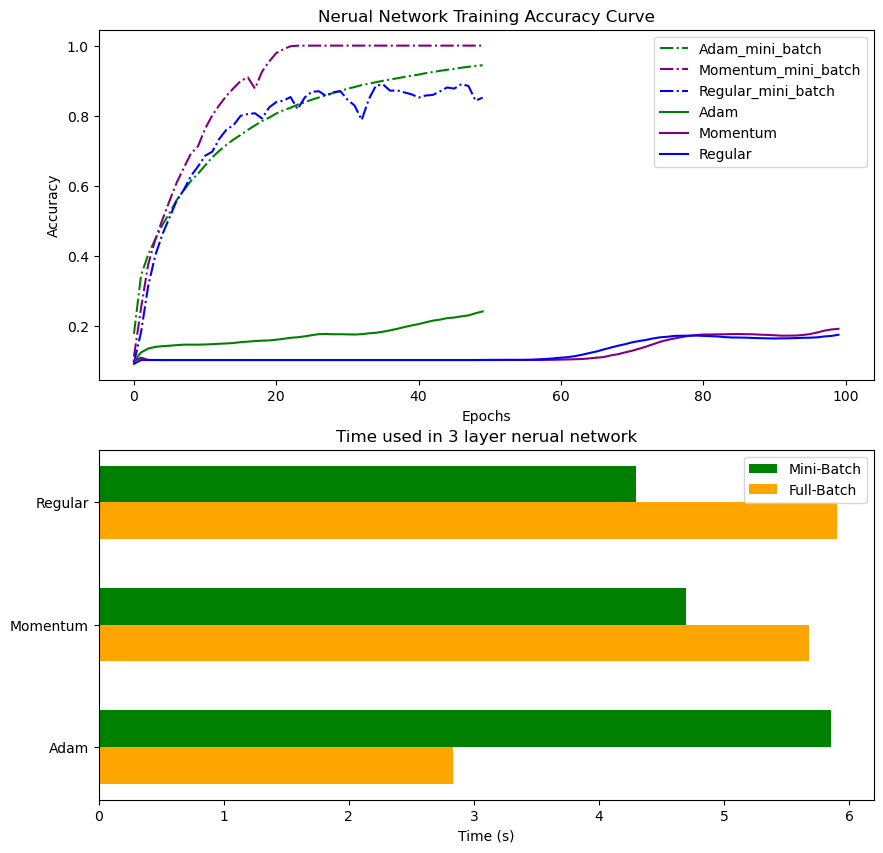

In [1246]:
fig, axs = plt.subplots(2, figsize=(10, 10))


axs[0].plot(Adam_nn_batch[0],'-.', label = 'Adam_mini_batch',color = 'green')
axs[0].plot(regu_nn_batch_mm[0],'-.', label = 'Momentum_mini_batch',color = 'purple')
axs[0].plot(regu_nn_batch[0], '-.', label = 'Regular_mini_batch',color = 'blue')
axs[0].plot(Adam_nn[0], label = 'Adam',color = 'green')
axs[0].plot(regu_nn_mm[0], label = 'Momentum',color = 'purple')
axs[0].plot(regu_nn[0], label = 'Regular',color = 'blue')

axs[0].title.set_text('Nerual Network Training Accuracy Curve')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()



x = np.arange(3)
axs[1].set_yticks(x,['Adam','Momentum','Regular'])
axs[1].set_xlabel('Time (s)')
axs[1].title.set_text('Time used in 3 layer nerual network')

axs[1].barh(x + 0.15,
            height = 0.3,
            width = [Adam_nn_batch[1], regu_nn_batch_mm[1], regu_nn_batch[1]],
            color = 'green',
            label = 'Mini-Batch')

axs[1].barh(x - 0.15,
            height = 0.3,
            width = [Adam_nn[1],regu_nn_mm[1], regu_nn[1]],
            color = 'orange',
            label = 'Full-Batch')
axs[1].legend()
plt.show()

fig.savefig('Train Result 3 layer.png')

##### ii. Model Accuracy Evaluation

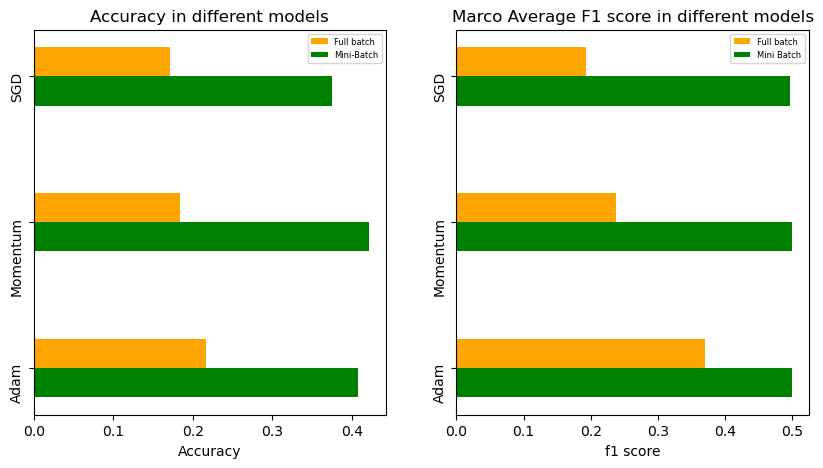

In [1247]:
acc_list = [Adam_nn_performance[0],regu_nn_mm_performance[0],regu_nn_performance[0]]
acc_list_batch = [Adam_nn_batch_performance[0],regu_nn_batch_mm_performance[0],regu_nn_batch_performance[0]]
f1_list = [Adam_nn_performance[1],regu_nn_mm_performance[1],regu_nn_performance[1]]
f1_list_batch = [Adam_nn_batch_performance[1],regu_nn_batch_mm_performance[1],regu_nn_batch_performance[1]]

fig, axs = plt.subplots(1,2, figsize=(10, 5))

x = np.arange(len(acc_list))

axs[0].barh(x+0.1,
         height = 0.2,
         width = acc_list,
         color = 'orange',
         label = 'Full batch')

axs[0].barh(x-0.1,
         height = 0.2,
         width = acc_list_batch,
         color = 'green',
         label ='Mini-Batch')

axs[0].set_title('Accuracy in different models')
axs[0].set_yticks(x,['Adam','Momentum','SGD'],rotation=90)
axs[0].set_xlabel('Accuracy')

axs[0].legend(fontsize="6")

x = np.arange(len(f1_list))

axs[1].barh(x+0.1,
         height = 0.2,
         width = f1_list,
         color = 'orange',
         label = 'Full batch')

axs[1].barh(x-0.1,
         height = 0.2,
         width = f1_list_batch,
         color = 'green',
         label ='Mini Batch')

axs[1].set_title('Marco Average F1 score in different models')
axs[1].set_yticks(x,['Adam','Momentum','SGD'],rotation=90)
axs[1].set_xlabel('f1 score')

axs[1].legend(fontsize="6")
plt.savefig('Eval_result.png')
plt.show()



### c. Regularize the model

##### i. Mini-Batch Normalization

In [1248]:
# Initalize the best model object
best_model = Model()

# Insert 1st Layer & Activation function
best_model.add(Layer_Dense(X.shape[1],128,norm=True))
best_model.add(Activation_ReLu())
best_model.add(Layer_Dropout(0.1))

# Insert 2nd Layer & Activation function
best_model.add(Layer_Dense(128,128,norm=True))
best_model.add(Activation_ReLu())
best_model.add(Layer_Dropout(0.1))

# Insert 3th layer and 
# The softmax loss function for multi-class loss
best_model.add(Layer_Dense(128,10,norm=True))
best_model.add(Activation_Softmax())

# Set the loss function, optimization, and Accuracy Calculation
best_model.set( loss = Loss_Cross_Entropy(),
                    optimizer = Adam(learning_rate=0.001,decay=1e-4,epsilon=1e-10,beta_1=0.9,beta_2=0.999),
                    eval = Metric_Cate() )
                    
# Connect the above layers accordingly
best_model.finalize()

# Train the finialized neural network models
best_model_norm = best_model.train(X_train,y_train,epochs=50,batch_size=128,print_by=128,verbose=0)
best_model_norm_performance = best_model.evaluation(X_valid,y_valid)

col_0     0     1     2     3     4     5     6     7     8     9    All
row_0                                                                   
0      1972   231   329   152   227   100    46   170   686   265   4178
1       225  2225    90   122    64    93    89    80   341   747   4076
2       321   105  1276   403   672   375   469   272   109    97   4099
3       165   142   374  1208   302   847   530   273   133   163   4137
4       186    47   664   236  1469   264   371   454   109    61   3861
5        65    59   329   820   231  1423   271   364    67    81   3710
6        49    81   379   442   437   304  1890   118    61    88   3849
7       122   112   282   298   412   366   132  1923    51   148   3846
8       598   282   101   104    91    67    55    43  2171   249   3761
9       289   744   139   204   112   145   129   308   325  2088   4483
All    3992  4028  3963  3989  4017  3984  3982  4005  4053  3987  40000
validation, acc: 0.441, f1_score: 0.500, loss: 2.34

#### ii. Weight Decay

In [1249]:
# Initalize the model object
best_model = Model()

# Insert 1st Layer & Activation function
best_model.add(Layer_Dense(X.shape[1],128,norm=True,weight_reg_l2=1e-4))
best_model.add(Activation_ReLu())
best_model.add(Layer_Dropout(0.1))

# Insert 2nd Layer & Activation function
best_model.add(Layer_Dense(128,128,norm=True, weight_reg_l2=1e-4))
best_model.add(Activation_ReLu())
best_model.add(Layer_Dropout(0.1))

# Insert 3th layer and 
# The softmax loss function for multi-class loss
best_model.add(Layer_Dense(128,10,norm=True,weight_reg_l2=1e-4))
best_model.add(Activation_Softmax())

# Set the loss function, optimization, and Accuracy Calculation
best_model.set( loss = Loss_Cross_Entropy(),
                    optimizer = Adam(learning_rate=0.001,decay=1e-4,epsilon=1e-10,beta_1=0.9,beta_2=0.999),
                    eval = Metric_Cate() )
                    
# Connect the above layers accordingly
best_model.finalize()

# Train the finialized neural network models
best_model_decay = best_model.train(X_train,y_train,epochs=50,batch_size=128,print_by=128,verbose=0)
best_model_decay_performance = best_model.evaluation(X_valid,y_valid)

col_0     0     1     2     3     4     5     6     7     8     9    All
row_0                                                                   
0      2110   295   346   172   260   101    57   181   749   316   4587
1       159  2076    70   122    52    78    74    75   244   686   3636
2       269    87  1289   378   592   409   383   235   125    68   3835
3       152   180   398  1260   310   934   546   335   147   199   4461
4       214    65   692   252  1527   252   472   457    96    71   4098
5        64    66   314   830   258  1366   296   370    65    86   3715
6        49   100   378   410   458   295  1828   124    41    96   3779
7       123   109   247   302   361   378   140  1934    47   186   3827
8       599   325   116   100    91    62    64    58  2276   295   3986
9       253   725   113   163   108   109   122   236   263  1984   4076
All    3992  4028  3963  3989  4017  3984  3982  4005  4053  3987  40000
validation, acc: 0.441, f1_score: 0.499, loss: 2.25

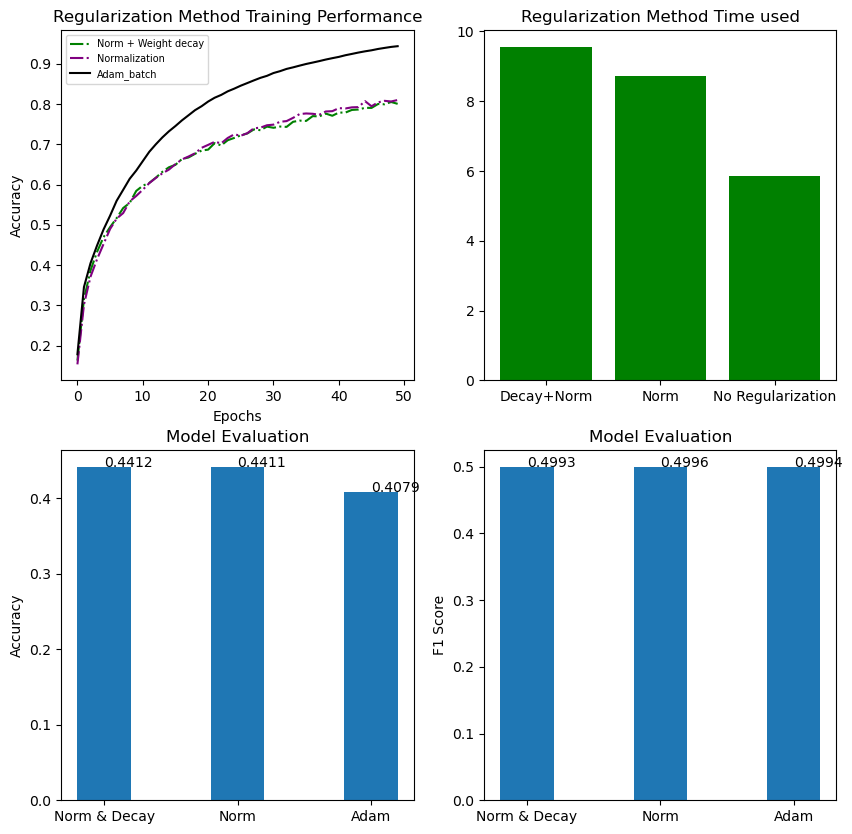

In [1250]:
def addlabels(x,y,graph):
    for i in range(len(x)):
        graph.text(i,y[i],y[i])

fig, axs = plt.subplots(2,2, figsize=(10, 10))


axs[0,0].plot(best_model_decay[0],'-.', label = 'Norm + Weight decay',color = 'green')
axs[0,0].plot(best_model_norm[0],'-.', label = 'Normalization',color = 'purple')
axs[0,0].plot(Adam_nn_batch[0], label = 'Adam_batch',color = 'black')

axs[0,0].title.set_text('Regularization Method Training Performance')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Accuracy')
axs[0,0].legend(fontsize=7)

axs[0,1].bar( x = ['Decay+Norm','Norm','No Regularization'],
              height = [best_model_decay[1], best_model_norm[1], Adam_nn_batch[1]],
              color = 'green')
axs[0,1].title.set_text('Regularization Method Time used')

axs[1,0].bar(['Norm & Decay','Norm','Adam'],
           [best_model_decay_performance[0],best_model_norm_performance[0],Adam_nn_batch_performance[0]],
           width=0.4)

axs[1,0].title.set_text('Model Evaluation')
axs[1,0].set_ylabel('Accuracy')

addlabels(['Norm & Decay','Norm','Adam'], 
          [best_model_decay_performance[0],
           best_model_norm_performance[0],
           Adam_nn_batch_performance[0]],
          axs[1,0])        

axs[1,1].bar(['Norm & Decay','Norm','Adam'],
           [best_model_decay_performance[1],best_model_norm_performance[1],Adam_nn_batch_performance[1]],
           width=0.4)

axs[1,1].title.set_text('Model Evaluation')
axs[1,1].set_ylabel('F1 Score')
addlabels(['Norm & Decay','Norm','Adam'], 
          [best_model_decay_performance[1],
           best_model_norm_performance[1],
           Adam_nn_batch_performance[1]],
          axs[1,1])        

plt.savefig('best model performance.png')

plt.show()


# 4.) Prediction

In [1251]:
confidences = Regular_model_batch.predict(X_test)
# Get prediction instead of confidence levels
predictions = Regular_model_batch.output_layer_activation.predictions(confidences)

In [1252]:
print('The prediction accuracy of our best tuned model is :',sum(Metric_Cate().compare(predictions,y_test))/y_test.shape[0])

The prediction accuracy of our best tuned model is : 0.3733
